### distribution functions

In [1]:
from numpy import pi as PI

import scipy
import numpy as np

# =============================================================================
#  ---------------- (DIS-)SIMILARITY DISTRIBUTION FUNCTIONS ------------------
# =============================================================================
def pdf_distance(t, kappa):
    """
    Cumulative distribution function of (circular) distance of two wrapped
    exponentialy distributed random variables with scale parameter kappa. 
    Support is on [0,pi].
    """
    support = np.where((0<t) & (t<PI), 1., 0.)
    return support * kappa/np.sinh(PI*kappa) * np.cosh((PI-t)*kappa)

def cdf_distance(t, kappa):
    """
    Cumulative distribution function of (circular) distance of two wrapped
    exponentialy distributed random variables with scale parameter kappa. 
    F(t)=0 for t<0 and F(t)=1 for t>pi.
    """
    support = np.where(0<=t, 1., 0.)
    term = 1 - np.sinh((PI-t)*kappa) / np.sinh(PI*kappa)
    return support * np.where(t>=PI,1,term)

def pdf_similarity(t, kappa, a):
    """
    Probability density function of s_a ∘ d(X,Y), where X,Y are two wrapped
    exponentially distributed random variables with scale parameter 1/kappa,
    d(-,-) denotes the distance on the circle and s_a(-) is the area of the
    (normalized) overlap of two boxes of length 2*pi*a on the circle for a
    given distance (measured from center to center). Normalization is taken
    to be the area of one box, 2*pi*a, to ensure the support being on [0,1].

    Function not implemented yet for a>0.5!
    """
    assert 0 <= a <= 0.5, f'Function not implemented yet for a>0.5! a={a}'

    support = np.where((0<=t) & (t<=1), 1., 0.)
    return support * 2*a*PI*pdf_distance(2*a*PI*(1-t), kappa)

def cdf_similarity(t, kappa, a):
    """
    Cumulative distribution function of s_a ∘ d(X,Y), where X,Y are two wrapped
    exponentially distributed random variables with scale parameter 1/kappa,
    d(-,-) denotes the distance on the circle and s_a(-) is the area of the
    (normalized) overlap of two boxes of length 2*pi*a on the circle for a
    given distance (measured from center to center). Normalization is taken
    to be the area of one box, 2*pi*a, to ensure the support being on [0,1].

    Function not implemented yet for a>0.5!
    """
    assert 0 <= a <= 0.5, f'Function not implemented yet for a>0.5! a={a}'

    support = np.where(0<=t, 1., 0.)
    term = 1 - cdf_distance(2*a*PI*(1-t), kappa=kappa)
    return support * np.where(t>=1, 1., term)

def mean_similarity(kappa, a):
    numer = 2*np.sinh(PI*kappa)*np.sinh((1-a)*PI*kappa)*np.sinh(a*PI*kappa)
    denom = a*PI*kappa*(np.cosh(2*PI*kappa)-1)
    return 1 - numer/denom

### network_model

In [2]:
from ringity.distribution_functions import mean_similarity, cdf_similarity
from scipy.spatial.distance import pdist, squareform
from numpy import pi as PI

import scipy
import numpy as np
import networkx as nx

# =============================================================================
#  -------------------------------  PREPARATION -----------------------------
# =============================================================================
def geodesic_distances(thetas):
    abs_dists = pdist(thetas.reshape(-1,1))
    return np.where(abs_dists<PI, abs_dists, 2*PI-abs_dists)


def overlap(dist, a):
    """
    Calculates the overlap of two boxes of length 2*pi*a on the circle for a
    given distance dist (measured from center to center).
    """

    x1 = (2*PI*a-dist).clip(0)
    if a <= 0.5:
        return x1
    # for box sizesw with a>0 there is a second overlap
    else:
        x2 = (dist-2*PI*(1-a)).clip(0)
        return x1 + x2    
    
def slope(rho, kappa, a):
    mu_S = mean_similarity(kappa,a)
    if rho <= mu_S:
        return rho/mu_S
    else:
        const = 1/np.sinh(PI*kappa)
        def integral(k):
            term1 = np.sinh((1 + 2*a*(1/k-1))*PI*kappa)
            term2 = (k*np.sinh((a*PI*kappa)/k)*np.sinh(((a+k-2*a*k)*PI*kappa)/k))/(a*PI*kappa)
            return term1-term2
        return scipy.optimize.newton(
            func = lambda k: const*integral(k) + (1-cdf_similarity(1/k, kappa, a)) - rho,
            x0 = rho/mu_S)

# =============================================================================
#  ------------------------------  NETWORK MODEL ----------------------------
# =============================================================================

def weighted_network_model(N, rho, beta, a=0.5, return_positions=False):
    """
    Returns samples of the Network model as described in [1]
    The outputs are samples of the
     - positions of the nodes placed on the circle according to a 
       (wrapped) exponential distribution,
     - their pairwise distances
     - their similarities, given an 'activity window' of size a
     - their connection probabilities, given the expected density rho.
    """

    # just maiking sure no one tries to be funny...
    
    assert 0 <= beta <= 1
    assert 0 <   a   <= 0.5
    assert 0 <= rho  <= 1
    
    if beta == 0:
        posis = np.zeros(N)
        probs = rho*np.ones_like(posis)
    elif beta == 1:
        assert rho < 2*a
        posis = np.random.uniform(0,2*PI, size=N)
        dists = geodesic_distances(posis)
        simis = overlap(dists, a)/(2*PI*a)
        
        if rho <= a:
            k = rho/mu_S
        else:
            raise Exception
    else:
        kappa = np.tan(PI*(1-beta)/2)
        assert rho < 1-np.sinh((PI-2*a*PI)*kappa) / np.sinh(PI*kappa)
        posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
        dists = geodesic_distances(posis)
        simis = overlap(dists, a)/(2*PI*a)
        probs = simis*slope(rho, kappa, a)
        
    if return_positions:
        return dists, probs
    else:
        return probs


def network_model(N, rho, kappa, a=0.5):
    """
    Network model as described in [1]. The output is the (empirical) positions
    of the nodes placed on the circle according to a von Mises distribution,
    followed by a tripple consisting of the (empirical) distribution of the
    pairwise distances, similarities and connection probabilities respectively.
    """
    probs = weighted_network_model(N = N,
                                   rho = rho,
                                   kappa = kappa,
                                   a = a)
    rands = np.random.uniform(size=round(N*(N-1)/2))
    A = squareform(np.where(probs>rands, 1, 0))
    G = nx.from_numpy_array(A)
    return G

# =============================================================================
#  ------------------------------ REFERENCES ---------------------------------
# =============================================================================

# [1] Not published yet.

## Here we go

In [10]:
from itertools import combinations
from scipy.integrate import quad

import numpy as np
import matplotlib.pyplot as plt

In [72]:
N = 2**13
rho = 0.15
a = 0.5
kappa = 0.01

In [81]:
N = 2**13
a = 0.1

posis = np.random.uniform(0,2*PI, size=N)
dists = geodesic_distances(posis)
simis = overlap(dists, a)/(2*PI*a)

In [82]:
np.mean(simis)

0.10002969710726285

In [25]:
posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
dists = geodesic_distances(posis)
simis = overlap(dists, a)/(2*PI*a)
#probs = simis*slope(rho, a, kappa)

(0.0, 6.283185307179586)

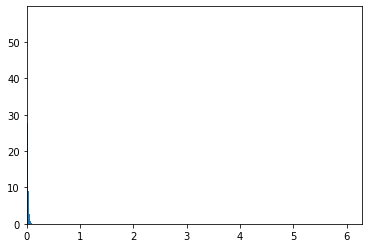

In [54]:
N = 2**16
beta = 0.01
kappa = np.tan(PI*(1-beta)/2)
posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
plt.hist(posis,bins=50, density=True);
ax = plt.gca()
ax.set_xlim(0,2*PI)
#plt.plot(x,y)

In [52]:
np.mean(posis)

0.01575585845026477

0.9999999999999999

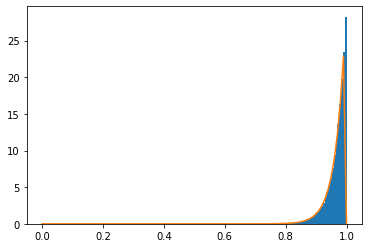

In [21]:
x = np.linspace(0,1,100)
y = pdf_similarity(x,kappa,a)

plt.hist(simis,bins=50, density=True);
plt.plot(x,y)

In [11]:
N = 2**10
G = network_model(N,rho,kappa=kappa,a=a)

In [12]:
nx.density(G), rho

(0.14829239980449657, 0.15)

In [13]:
N = 2**12
a = 0.3
kappa = 0.6

centers = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
dists = geodesic_distances(centers)
simis = overlap(dists, a)/(2*PI*a)

In [17]:
np.mean(simis), mu_similarity(kappa, a)

(0.4213724491397234, 0.4308098918007214)

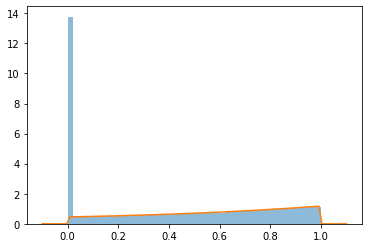

In [18]:
x = np.linspace(-0.1,1.1, 100)
f_X = kappa*np.exp(-kappa*x)/(1-np.exp(-2*PI*kappa))
f_D = pdf_similarity(x, kappa, a)

plt.hist(simis  , bins=50, alpha=0.50, density=True);
plt.plot(x, f_D)

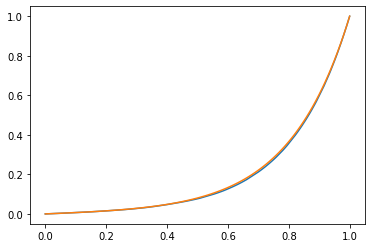

In [31]:
thetas = np.linspace(0,1,100)
x = np.sort(simis)
y = np.linspace(0,1,len(x))
plt.plot(x, y)
plt.plot(thetas, cdf_similarity(thetas, kappa, a))

In [15]:
1-cdf_distance(2*PI*a, kappa)

0.6677051249253559

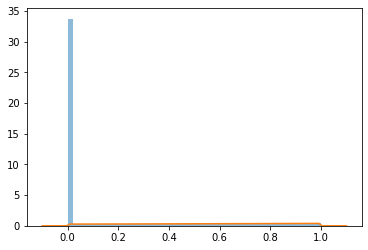

In [17]:
x = np.linspace(-0.1,1.1, 100)
f_X = kappa*np.exp(-kappa*x)/(1-np.exp(-2*PI*kappa))
f_D = pdf_similarity(x, kappa, a)

plt.hist(simis  , bins=50, alpha=0.50, density=True);
plt.plot(x, f_D)

In [8]:
from itertools import product

In [124]:
for rho, a, kappa in product(np.linspace(0.01,0.99,5),np.linspace(0.5,0,5,endpoint=False),np.logspace(-2,2,5)):
    test = abs(old(rho,kappa,a)-new(rho,kappa,a))
    if test < 10**(-10):
        continue
    else:
        print(rho,a,kappa)
        print(test)
        print()

/Users/markusyoussef/Desktop/git/supplements/venv/ringity/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in sinh
/Users/markusyoussef/Desktop/git/supplements/venv/ringity/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


In [9]:
N = 2**9

for rho, a, kappa in product(np.linspace(0.01,0.99,5),np.linspace(0.5,0,5,endpoint=False),np.logspace(-2,2,5)):
    try:
        G = network_model(N,rho,kappa,a)
    except AssertionError:
        continue
    dens = nx.density(G)
    if abs(dens-rho)>0.01:
        print(dens, rho)
        print(rho, a, kappa)
        print()

0.24133133561643835 0.255
0.255 0.19999999999999996 1.0

0.5139738258317026 0.5
0.5 0.19999999999999996 1.0



In [51]:
def old(rho, kappa, a):
    mu_S = mu_similarity(kappa,a)
    if rho <= mu_S:
        return rho/mu_S
    else:
        const = 1/np.sinh(PI*kappa)
        def integral(k):
            return np.sinh((1 + 2*a*(1/k-1))*PI*kappa) - (k*np.sinh((a*PI*kappa)/k)*np.sinh(((a+k-2*a*k)*PI*kappa)/k))/(a*PI*kappa)
        return scipy.optimize.newton(
            func = lambda k: const*integral(k) + (1-cdf_similarity(1/k, kappa, a)) - rho,
            x0 = rho/mu_S)
    
def new(rho, kappa, a):
    mu_S = mu_similarity(kappa,a)
    if rho <= mu_S:
        return rho/mu_S
    else:
        const = 1/np.sinh(PI*kappa)
        def integral(k):
            term1 = np.sinh((1 + 2*a*(1/k-1))*PI*kappa)
            term2 = (k*np.sinh((a*PI*kappa)/k)*np.sinh(((a+k-2*a*k)*PI*kappa)/k))/(a*PI*kappa)
            return term1-term2 
        return scipy.optimize.newton(
            func = lambda k: const*integral(k) + (1-cdf_similarity(1/k, kappa, a)) - rho,
            x0 = rho/mu_S)


for rho, a, kappa in product(np.linspace(0.01,0.99,5),np.linspace(0.5,0,5,endpoint=False),np.logspace(-2,2,5)):
    if 1-rho < np.sinh((PI-2*a*PI)*kappa) / np.sinh(PI*kappa):
        continue
        
    k1 = old(rho, kappa, a)
    k2 = new(rho, kappa, a)
    
    test = abs(k1-k2)
    
    if test > 10**(-10):
        print(test)
        print(rho, a, kappa)
        print()

In [49]:
k1, k2

(0.999904649372805, 1.007573052806244)

In [171]:
kappa/np.sinh(PI*kappa) * np.cosh((PI-2*a*PI*(1-u))*kappa) 

In [104]:
G = network_model(N,rho,kappa,a)

In [105]:
nx.density(G)

0.36086991385630496

In [106]:
posis = np.random.exponential(scale=1/kappa, size=N) % (2*PI)
dists = geodesic_distances(posis)
simis = overlap(dists, a)/(2*PI*a)
probs = (simis*slope(rho, kappa, a)).clip(0,1)

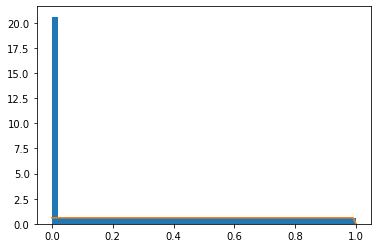

In [108]:
x = np.linspace(0,1,100)
y = pdf_similarity(x,kappa,a)

plt.hist(simis,bins=50, density=True)
plt.plot(x,y)

In [110]:
np.mean(simis), mu_similarity(kappa,a)

(0.2996957829586482, 0.300048356543551)

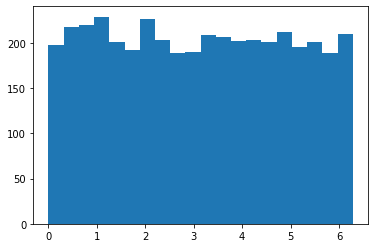

In [59]:
plt.hist(np.random.uniform(0,2*PI, size=2**12), bins=20);

In [60]:
np.sinh((PI-2*a*PI)*0)

0.0

In [65]:
a = 0.3

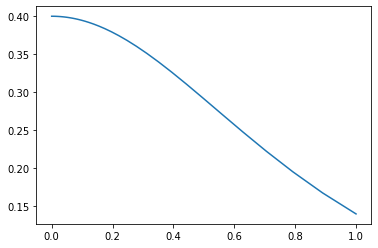

In [68]:
x = np.logspace(-5,0,100)
y = np.sinh((PI-2*a*PI)*x) / np.sinh(PI*x)

plt.plot(x,y)

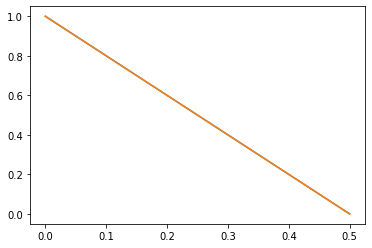

In [71]:
x = np.linspace(0,0.5,20)
y = np.sinh((PI-2*x*PI)*0.00001) / np.sinh(PI*0.00001)

plt.plot(x,y)
plt.plot(x,1-2*x)